# General Explanation:

In the present jupyer notebook, we will desglose the work for characterizing how entanglement is relevant in the anastz embedding and in the finding of the ground state for quantum chemistry problems.

Preeliminaries:

In Variational Quantum Algorithms (VQA), It is usual to define a cost function, given a Quantum State $\rho$ and an Observable $\mathcal{O}$ such that:

$$
C(\rho, \mathcal{O}) = \text{Tr}(\rho \mathcal{O})
$$
and then minimize it or optimize it in order to tackle down optimization Problems.

An issue with this method, is that often exploring the whole landscape of states it's an exponential task. (the so-called curse of dimensionality)

Several methods have been developed utilizing the stabilizer formalism, correct walk at the Hilbert Space, and so on.

In this case, we are going to explore how different classes of entanglement can contribute to find the ground state of a molecular Hamiltonian.

For this case, we now that a Molecular Hamiltonian can be expresed by the electronic structure Hamiltonian, $\mathcal{H}_{\text{ES}}$:

$$
\mathcal{H}_{\text{ES}} =  T_{N} + T_{e} + V_{ee}^{\text{Coulomb}} + V_{en}^{\text{Coulomb}} + V_{nn}^{\text{Coulomb}}
$$

Where $T_{N}, T_{e} $ are the kinetic energy of the Nuclei and electrons, respectively, while $V_{ee}^{\text{Coulomb}}, V_{en}^{\text{Coulomb}}, V_{nn}^{\text{Coulomb}}$ are the coulomb interactions between electron-electron, electron-nuclei and nuclei-nuclei respectively.

In this case, by utilizing the B-O approx, we are going only to center on the 2nd, 3rd and 4th term. (which is a valid approximation because we want to focuse on the low-energy regime)

In order to avoid the problem of barren plateau and correct ansatz preparation, we are going to characterize how well does different states of different classes computes the GS for 4-qubit problems.

The idea is to reach all the Hilbert Space in these sub division of states, and the utilizing later to tackle down more efficiently these problems.



# Beggining:

first, we are going to install the necesary packages:

In [2]:
%pip install qutip
%pip install pyscf
%pip install qiskit_nature


[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Operator creation:

In this part, we are going to construc the Unitary operators that are going to be layered in the final class.

In [3]:
#We import the necesary libraries:
import qutip as qt
from qutip import Bloch, QobjEvo, basis, sesolve, sigmay, sigmaz
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt
from scipy.constants import h, e


In [4]:
def unitary(theta: float, phi: float, lamb) -> np.ndarray:
    """
    The typical unitary matrix of a single qubit gate, 
    parametrized as usual with only three rotational angle parameter.
    """
    c = np.cos(theta / 2)
    s = np.sin(theta / 2)
    e_phi = np.exp(1j * phi)
    e_lamb = np.exp(1j * lamb)

    return np.array([[c,                - e_lamb * s],
                     [-e_phi * s,    e_lamb * e_phi * c  ]])



def U_qubit(N : int, k : int, params : np.array ):
    
    """
    N: number of total qubits
    k: label of the target qubit to apply the local unitary U
    params: list or array where it contains the parameters that characterize the unitary
    """

    # we define the matrix 
    U = unitary(*params)

    # Converts from numpy array to Qobj of Qutip
    U_qobj = qt.Qobj(U)

    # We construct the tensorized operator in qutip
    L = [qt.qeye(2)] * N  # Lista con Identidades en todos los sitios
    L[k] = U_qobj  # Sustituye en el qubit k
    return qt.tensor(L)




In [5]:
# Num of qubits
N = 4  

# Vector de parámetros (12 elementos en total: 3 por cada qubit)

#question: why these values?
#can this affect the convergence time?
params_vec = [np.pi/4, np.pi/3, np.pi/6,  # Qubit 0
              np.pi/2, np.pi/4, np.pi/8,  # Qubit 1
              np.pi/3, np.pi/6, np.pi/2,  # Qubit 2
              np.pi/8, np.pi/3, np.pi/4]  # Qubit 3

params_vecV2 = np.random.uniform(0, 2*np.pi, 12)

# Now we generate the unitary operators for each qubit

dict_op = {f'U_{i}': U_qubit(N, i, params_vec[3*i: 3*(i+1)]) for i in range(N)}


# Comprobamos los operadores generados
#print(dict_op['U_1'])
#...

In this part, we are going to construct The operator $\mathcal{H}_{\text{ES}}$. In order to do this we are going to utilize the PySCF package together with Qiskit Nature package:

With this form, we can express the hamiltonian as a QuTIP object.

In [6]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper

def H2_Hamiltonian_Operator(r_i):
    """
    This function returns the Hamiltonian operator of the H2 
    molecule at a given distance r_i.
    
    args:
        r_i: distance between the two hydrogen atoms
    """
    
    driver = PySCFDriver(
        atom= f'H .0 .0 .0; H .0 .0 {r_i}',
        unit = DistanceUnit.ANGSTROM,
        basis= 'sto-3g',
    )

    problem = driver.run()
    second_q_ham = problem.hamiltonian.second_q_op()

    mapper = JordanWignerMapper()

    pauli_hamiltonian_op = mapper.map(second_q_ham)
    matrix_representation = pauli_hamiltonian_op.to_matrix()
    qt_hamiltonian_op = qt.Qobj(matrix_representation, dims=[[2,2,2,2], [2,2,2,2]])
    
    return qt_hamiltonian_op


In [9]:
# me base de esto para escribir lo de abajo...

#N = 4
#s0 = qt.basis(2, 0)
#s1 = qt.basis(2, 1)

#ESTADOS DE CADA CLASE DE ENTRELAZAMIENTO
#psi_C9 = 1/2*(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s1,s0,s1)+qt.tensor(s1,s0,s1,s0) + qt.tensor(s1,s1,s1,s1) )
#psi_C3 = 1/np.sqrt(2)*(qt.tensor(s0,s0,s0,s0)+ qt.tensor(s1,s0,s1,s0))
#psi_C1 = qt.tensor(s0,s0,s0,s0)
#psi_C11 = 1/np.sqrt(3)*(qt.tensor(s0,s0,s1,s0)+qt.tensor(s0,s1,s0,s0)+qt.tensor(s1,s0,s0,s0))
#psi_C15 = 1/np.sqrt(2)*(qt.tensor(s0,s0,s0,s0)+ qt.tensor(s1,s1,s1,s0))
#psi_C19 = 1/2*(qt.tensor(s1,s0,s0,s0)+qt.tensor(s0,s1,s0,s0)+qt.tensor(s0,s0,s1,s0)+ qt.tensor(s0,s0,s0,s1))
#psi_C26 = 1/np.sqrt(2)*(qt.tensor(s0,s0,s0,s0)+qt.tensor(s1,s1,s1,s1))
#psi_C48 = 1/np.sqrt(8)*(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s0,s1,s1)+qt.tensor(s0,s1,s0,s1)+qt.tensor(s0,s1,s1,s0)+qt.tensor(s1,s0,s0,s0)-qt.tensor(s1,s0,s1,s1)+qt.tensor(s1,s1,s0,s1)-qt.tensor(s1,s1,s1,s0))


Aqui haré lo siguiente:

1) Creare una funcion `initialize_state(state_vector : np.array):` para que inicialize el objeto de qutip teniendole que darle solo la repr vectorial como un numpy array para que sea mas facil de generar los estados de manera arbitraria. De esta manera, podemos ver que los estados que utilizaremos serán:
$$
\ket{C_1} = \ket{0000} \\ \\

\ket{C_3} = \frac{1}{\sqrt{2}} \big ( \ket{0000} + \ket{1010}  \big) \\ \\

\ket{C_9} = \frac{1}{2} \big ( \ket{0000} + \ket{0101} + \ket{1010} + \ket{1111} \big)  \\ \\

\ket{C_{11}} = \frac{1}{\sqrt{3}} \big (  \ket{0010} + \ket{0100} + \ket{1000}     \big ) = \ket{W} \otimes \ket{0} \\ \\

\ket{C_{15}} = \frac{1}{\sqrt{2}} \big ( \ket{0000} + \ket{1110}  \big)                   = \ket{GHZ} \otimes \ket{0} \\ \\

\ket{C_{19}} = \frac{1}{2} \big ( \ket{1000} + \ket{0100} + \ket{0010} + \ket{0001}\big) = \text{CNOT}_{q_2 \to q_3} \ket{W} ??? \\ \\

\ket{C_{26}} = \frac{1}{\sqrt{2}} \big ( \ket{0000} + \ket{1111}  \big) = \ket{GHZ}_4 \\ \\

\ket{C_{48}} = \frac{1}{\sqrt{8}} \big( \ket{0000} + \ket{0011} + \ket{0101} + \ket{0110} + \ket{1000} - \ket{1011} + \ket{1101} - \ket{1110} \\ \\
  \big ) \\ \\

\text{We need to fill up the 27 states... cositas se vienen!}
$$

where we are going to utilize the notation of: $\ket{q0, q1, q2, q3}$

2) luego, crearé una función que aplique el ansatz a utilizar `apply_ansatz(qt_state_vector : qt.tensor, params_vector : np.array):` , que será explorar de manera constante el espacio de Hilbert, en función de los posibles estados que pertenezcan a una misma clase. Para poder lograr esto es utilizar la definición matemática de similitud bajo transformaciones unitarias locales: $\ket{\psi'} = U \ket{\psi}$ para nuestro caso, esto se logra definiendo $U = U(\theta_0, \phi_0, \lambda_0) \otimes U(\theta_1, \phi_1, \lambda_1) \otimes U(\theta_2, \phi_2, \lambda_2) \otimes U(\theta_3, \phi_3, \lambda_3)$ y optimizaremos de manera manera constante con respecto a cada una de las clases, y que crece de manera lineal con el numero de qubits: ( ` Num_of_param = 3*N ` ).

Al final, lo que hacemos es algo así:


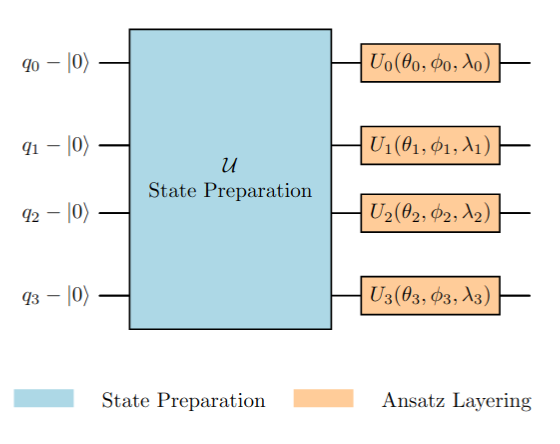

3) Inicializar el Hamiltoniano y con el estado final $\ket{\psi}(\vec{\theta})$ calcular el valor de expectación de este operador que ya sabemos como hacerlo. Aqui generaremos la famosa función de costo: $\langle \mathcal{H}_{\text{ES}} \rangle (\vec{\theta})$ esto lo haremos con el codigo que ya estaba del Diego con el método `qt.expect(H, state)`

4) ver que tanto se parecen estos resultados al resultado de referencia:

Aqui hago una hipotesis/pregunta: ¿Habrán clases que lo hagan mejor en unos regimenes (por ej, regimen de equilibrio lo harán mejor los estados separables, mientras que en regimenes disosiativos serán mejor estados que si presenten cierto grado de entrelazamiento?)?

Es posible que una interpretación del entrelazamiento, se manifieste cuando es necesario utilizar el multiconfiguration formalism/una forma de ver que tanto ven los unos de los otros al mismo tiempo???? interpretacion de quantum mechanics lolaso..




In [10]:
def initialize_state(state_vector : np.array) -> qt.tensor:

    # We define the basis of one qubit
    s_0 = qt.basis(2, 0)
    s_1 = qt.basis(2, 1)
    basis_states = [s_0, s_1]

    # We construct the quantum state as intended 
    quantum_state = sum(
        state_vector[i] * qt.tensor(
            basis_states[(i >> 3) & 1],  # Qubit 1
            basis_states[(i >> 2) & 1],  # Qubit 2
            basis_states[(i >> 1) & 1],  # Qubit 3
            basis_states[(i >> 0) & 1]   # Qubit 4
        )
        for i in range(16)
    )

    # We normalize the state:
    quantum_state = quantum_state.unit()
    return quantum_state


def apply_ansatz(qt_state_vector : qt.tensor, params_vector : np.array) -> qt.tensor:


    U_i = [U_qubit(N, i, params_vector[3*i: 3*(i+1)]) for i in range(4)]

    layered_state = U_i[3] * U_i[2] * U_i[1] * U_i[0] * qt_state_vector

    return layered_state

    #TO DO: try to implement this in a more efficient and general way...
    """
    # Create a dictionary of unitary operators for each qubit using U_qubit
    dict_op = {f'U_{i}': U_qubit(N, i, params_vector[3*i: 3*(i+1)]) for i in range(N)}
    
    # Initialize the layered_state as the identity (no operation)
    layered_state = qt.qeye(2**N)  # Identity matrix of dimension 2^N
    
    # Apply each unitary operator to the state vector
    for i in range(N):
        # Apply the tensor product of all U_i up to i-th qubit


        layered_state = qt.tensor(*[dict_op[f'U_{j}'] if j == i else qt.qeye(2) for j in range(N)]) * qt_state_vector

    return layered_state
    """


def cost_func(params_vec : np.array, *args) -> float:
    """
    Function to optimize: we will be optimizing the set of parameters of the Unitary.

    Args:
        params_vec: array of parameters for the Unitary.
        Hamiltonian: Hamiltonian operator of the system.
        state_vector: initial state of the system.
        N: number of qubits in the system.

    Returns:
        float: Expectation value of the Hamiltonian for the given state and parameters.    
    """
    Hamiltonian = args[0]
    state_vector = args[1]

    initial_class_state = initialize_state(state_vector)
    ansatz = apply_ansatz(initial_class_state, params_vec)

    return qt.expect(Hamiltonian, ansatz)


In [11]:
#dataset_clases


#psi_class = give here the np.array(statevector...):
#For simplisity, I'm going to put only C1, C3, C9, C26 and C48
#find a clever way to do this, it does not matter a lot bcs is initialized once but it works by now...
# At the moment I'm utilizing the module qiskit.quantum_info to initialize it with the usual nomenclature of 
# |0000>, |1010>, etc...

from qiskit.quantum_info import Statevector as SV

dataset_classes = {
    'C1' : SV.from_label('0000').data,
    'C3' : SV.from_label('0000').data + SV.from_label('1010').data,
    'C9' : SV.from_label('0000').data + SV.from_label('0101').data + SV.from_label('1010').data + SV.from_label('1111').data,
    'C11' : SV.from_label('0010') + SV.from_label('0100') + SV.from_label('1000'),
    'C15' : SV.from_label('0000').data + SV.from_label('1110').data,
    'C19' : SV.from_label('1000').data + SV.from_label('0100').data + SV.from_label('0010').data + SV.from_label('0001').data,
    'C26' : SV.from_label('0000').data + SV.from_label('1111').data,
    'C48' : SV.from_label('0000').data + SV.from_label('0011').data + SV.from_label('0101').data + SV.from_label('0110').data + SV.from_label('1001').data - SV.from_label('1010').data + SV.from_label('1101').data - SV.from_label('1110').data

}

final_dataset = {key : state / np.linalg.norm(state) for key, state in dataset_classes.items()}
availiable_classes = [key for key in final_dataset.keys()]

# Here the dataset is in the form of { Ci : |Ci> }
# Where Ci is the name of the class (str) and |Ci> the statevector of the class (np.array)

print(availiable_classes)



['C1', 'C3', 'C9', 'C11', 'C15', 'C19', 'C26', 'C48']


In [12]:
import numpy as np
from scipy.optimize import minimize


distances = np.arange(0.05, 4.5, 0.05)

# Definir los límites de los parámetros de manera más eficiente
bounds = [(0, np.pi) if i % 3 == 0 else (0, 2 * np.pi) for i in range(12)]

try_initial_psi_class = dataset_classes['C1']

energies = np.zeros(shape= (len(availiable_classes), len(distances) ))

for i, Ci in enumerate(availiable_classes):
    try_initial_psi_class = dataset_classes[Ci]
    for j, rj in enumerate(distances):
        # We first initialize our Hamiltonian & choose the quantum state
        # perteneciente a la clase C_i
        qt_H2_hamiltonian = H2_Hamiltonian_Operator(rj)

        # Inicialización de los parámetros aleatorios dentro de los límites
        init_params_vec = np.array([np.random.uniform(low, high) for low, high in bounds])

        # Argumentos de la función de costo
        
        args1 = (qt_H2_hamiltonian, try_initial_psi_class)  # Estado de la clase de entrelazamiento, Hamiltoniano de la molécula

        # Minimización usando COBYLA
        VQE = minimize(cost_func, init_params_vec, args=args1,
                    method='COBYLA', bounds=bounds, 
                    options={'maxiter': 1500, 'disp': True})

        energies[i][j] = VQE.fun


    


   Normal return from subroutine COBYLA

   NFVALS =  144   F =-2.602568E+00    MAXCV = 8.222657E-18
   X =-8.222657E-18   3.897288E+00   6.206584E+00   3.141593E+00   3.866474E+00
       1.893810E+00   4.622232E-33   6.283185E+00   5.294392E+00   3.141493E+00
       2.342120E+00   4.330709E+00

   Normal return from subroutine COBYLA

   NFVALS =  148   F =-2.575885E+00    MAXCV = 9.860761E-32
   X =-9.860761E-32   9.726918E-01   5.052149E+00   3.141593E+00   4.728947E+00
       4.737758E+00   1.000000E-04   6.283185E+00   3.555179E+00   3.141593E+00
       4.888225E+00   1.501482E+00

   Normal return from subroutine COBYLA

   NFVALS =  175   F =-2.534383E+00    MAXCV = 3.768184E-28
   X =-3.768184E-28   6.283185E+00   4.191813E+00   3.141593E+00   1.889460E-01
       9.908845E-01   2.482534E-21   4.644168E+00   2.395711E+00   3.141493E+00
       4.425833E+00   1.607642E+00

   Normal return from subroutine COBYLA

   NFVALS =  133   F =-2.481711E+00    MAXCV = 1.990768E-26
   X =-

In [ ]:
# Create a dictionary where the key is 'Ci' and the value is a tuple (distances, energies)
data_dict = {}

for i, Ci in enumerate(availiable_classes):
    energies_for_class = energies[i]  # Energies for this class (for all distances)
    data_dict[Ci] = (distances, energies_for_class)

# Save the dictionary
np.savez("energies_distances.npz", **data_dict)


# Load the saved dictionary
loaded_data = np.load("energies_distances.npz", allow_pickle=True)

# Access data for a specific class, e.g., 'C1'
C1_distances, C1_energies = loaded_data['C1']

print(f"C1 distances: {C1_distances}")
print(f"C1 energies: {C1_energies}")


# I did this because as we find more classes, we only compute the VQE for that class in specific    

/tmp/ipykernel_24371/1605123729.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(availiable_classes))


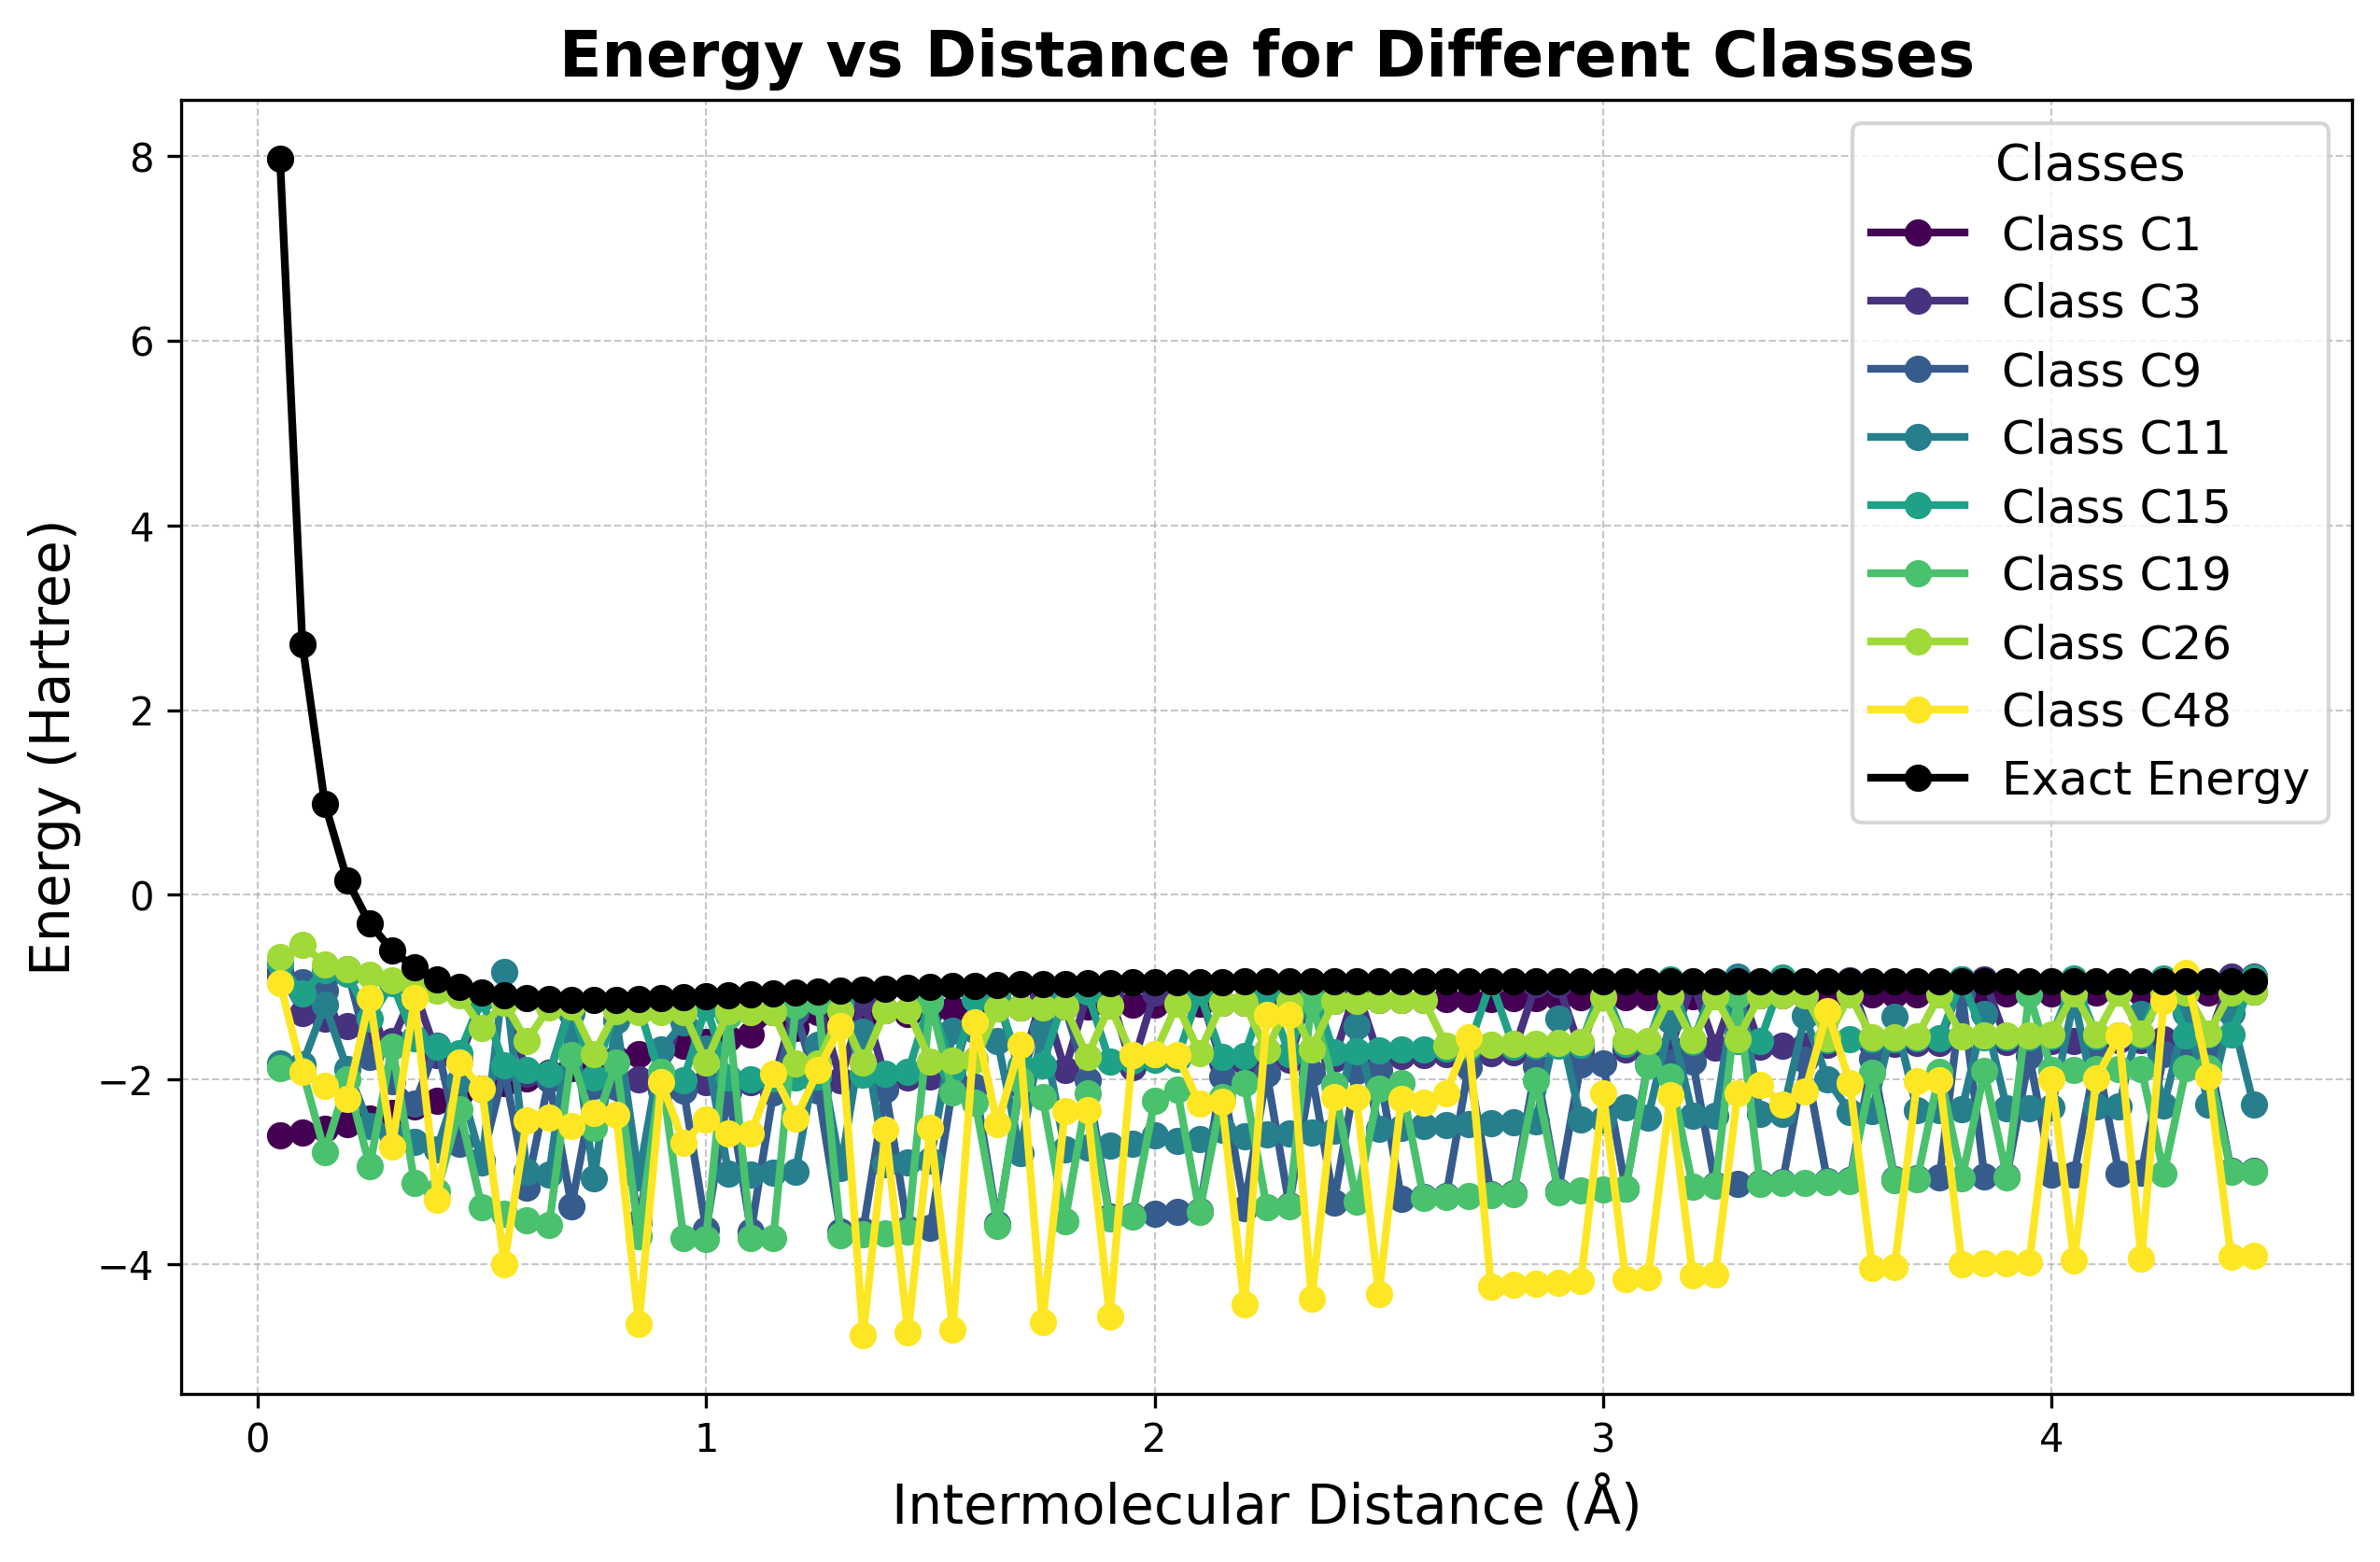

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Create a color map (Viridis) with as many colors as the number of classes
cmap = cm.get_cmap('viridis', len(availiable_classes))

plt.figure(figsize=(10, 6), dpi=300)  # High-quality figure

# Loop over each class and assign colors from the Viridis colormap
for i, Ci in enumerate(availiable_classes):
    color = cmap(i / len(availiable_classes))  # Normalize index to [0,1] for colormap
    plt.plot(distances, energies[i], 'o-', label=f'Class {Ci}', color=color, linewidth=2, markersize=6)



reference_H2 = np.load("reference_H2_energy.npy")

plt.plot(distances, reference_H2, 'o-', label='Exact Energy', color='black', linewidth=2, markersize=6)


# Labels, title, and styles
plt.xlabel('Intermolecular Distance (Å)', fontsize=14)
plt.ylabel('Energy (Hartree)', fontsize=14)
plt.title('Energy vs Distance for Different Classes', fontsize=16, fontweight='bold')

#Esto es para hacer zoom automatico
#plt.xlim((0.3, 1))


# Aesthetic improvements
plt.legend(title='Classes', fontsize=12, title_fontsize=13, loc='best', frameon=True)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Show the plot
plt.show()
